In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from statsmodels.tsa.arima.model import ARIMA


In [ ]:
def load_data(filepath):
    data = pd.read_csv(filepath)
    print(data.info())
    print(data.describe())
    return data

In [ ]:
def visualize_data(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    data.hist(bins=30, figsize=(15, 10), edgecolor='black')
    plt.tight_layout()
    plt.show()

In [ ]:
def feature_engineering(data):
    data['Pressure Sum'] = data['Lub oil pressure'] + data['Fuel pressure']
    data['Pressure Difference'] = data['Fuel pressure'] - data['Coolant pressure']
    data['RPM Coolant Pressure Product'] = data['Engine rpm'] * data['Coolant pressure']
    data['Lub Oil to Coolant Temp Ratio'] = data['lub oil temp'] / (data['Coolant temp'] + 1e-5)
    return data

In [ ]:
def preprocess_data(data, target_column, test_size=0.3, random_state=42):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test, X.columns

In [ ]:
def train_random_forest(X_train, y_train, X_test, y_test):

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    print("\nRandom Forest Model Performansı:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return rf

In [ ]:
def train_autoencoder(X_train, epochs=50, batch_size=32):

    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    history = autoencoder.fit(
        X_train, X_train,
        epochs=epochs, batch_size=batch_size,
        validation_split=0.2, shuffle=True
    )

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Autoencoder Kayıp Grafiği')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return autoencoder

In [ ]:
load_data('engine_data.csv')
autoencoder = train_autoencoder(X_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB
None
         Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  \
count  19535.000000      19535.000000   19535.000000      19535.000000   
mean     791.239263          3.303775       6.655615          2.335369   
std      267.611193          1.021643       2.761021          1.036382   
min       61.000000          0.003384       0.003187          0.002483   
25%      593.000000          2.518815       

NameError: name 'X_train' is not defined

In [ ]:
def detect_anomalies_with_autoencoder(autoencoder, X_train, X_test, threshold_percentile=95):
    reconstructed_train = autoencoder.predict(X_train)
    mse_train = np.mean(np.power(X_train - reconstructed_train, 2), axis=1)
    threshold = np.percentile(mse_train, threshold_percentile)

    reconstructed_test = autoencoder.predict(X_test)
    mse_test = np.mean(np.power(X_test - reconstructed_test, 2), axis=1)
    anomalies = mse_test > threshold

    plt.figure(figsize=(10, 6))
    plt.hist(mse_test, bins=50, alpha=0.75, label="MSE (Test)")
    plt.axvline(threshold, color='r', linestyle='--', label="Threshold")
    plt.title("Anomaliler ve Yeniden Yapılandırma Hatası Dağılımı")
    plt.xlabel("Reconstruction Error")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    return threshold, anomalies, mse_test, reconstructed_test

threshold, anomalies, mse_test, reconstructed_test = detect_anomalies_with_autoencoder(autoencoder, X_train, X_test)

NameError: name 'autoencoder' is not defined

Anomalilere En Fazla Katkı Sağlayan Özellikler:
            Feature  Contribution
2     Fuel pressure      1.271153
3  Coolant pressure      1.156862
1  Lub oil pressure      1.019207
0        Engine rpm      0.840373
4      lub oil temp      0.815523
5      Coolant temp      0.756093


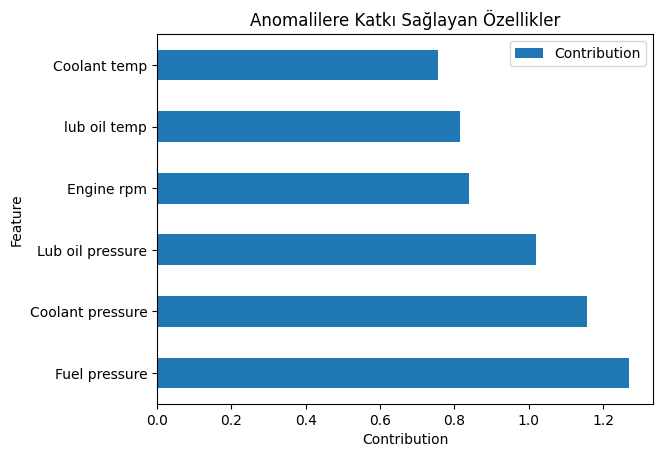

In [ ]:
def analyze_feature_contribution(X_test, reconstructed_test, anomalies, feature_names):
    reconstruction_errors = np.abs(X_test - reconstructed_test)
    feature_contribution = np.mean(reconstruction_errors[anomalies], axis=0)

    important_features = pd.DataFrame({
        "Feature": feature_names,
        "Contribution": feature_contribution
    }).sort_values(by="Contribution", ascending=False)

    print("Anomalilere En Fazla Katkı Sağlayan Özellikler:")
    print(important_features)

    important_features.plot(kind='barh', x='Feature', y='Contribution', title='Anomalilere Katkı Sağlayan Özellikler')
    plt.xlabel('Contribution')
    plt.ylabel('Feature')
    plt.show()

    return important_features

important_features = analyze_feature_contribution(X_test, reconstructed_test, anomalies, feature_names)

In [ ]:
selected_features = [
    'Pressure Difference',
    'Fuel pressure',
    'Pressure Sum',
    'RPM Coolant Pressure Product',
    'Coolant pressure'
]

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

X_train_df['Pressure Sum'] = X_train_df['Lub oil pressure'] + X_train_df['Fuel pressure']
X_train_df['Pressure Difference'] = X_train_df['Fuel pressure'] - X_train_df['Coolant pressure']
X_train_df['RPM Coolant Pressure Product'] = X_train_df['Engine rpm'] * X_train_df['Coolant pressure']

X_test_df['Pressure Sum'] = X_test_df['Lub oil pressure'] + X_test_df['Fuel pressure']
X_test_df['Pressure Difference'] = X_test_df['Fuel pressure'] - X_test_df['Coolant pressure']
X_test_df['RPM Coolant Pressure Product'] = X_test_df['Engine rpm'] * X_test_df['Coolant pressure']

X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]

In [ ]:
def detect_anomalies_with_isolation_forest(X_train, X_test, contamination=0.05, random_state=42):
    """
    Isolation Forest kullanarak anomali tespiti yapar.
    """
    iso_forest = IsolationForest(contamination=contamination, random_state=random_state)
    iso_forest.fit(X_train)

    anomaly_scores = iso_forest.decision_function(X_test)
    anomaly_labels = iso_forest.predict(X_test)

    X_test_with_scores = X_test.copy()
    X_test_with_scores['Anomaly_Score'] = anomaly_scores
    X_test_with_scores['Anomaly_Label'] = anomaly_labels

    return X_test_with_scores, anomaly_scores, anomaly_labels

In [ ]:
def find_common_anomalies(autoencoder_anomalies, iso_forest_anomalies):

    common_anomalies_indices = autoencoder_anomalies.index.intersection(iso_forest_anomalies.index)
    return common_anomalies_indices

In [ ]:
def visualize_common_anomalies(data, x_feature, y_feature, common_indices):

    common_anomalies = data.loc[common_indices]
    plt.figure(figsize=(10, 6))
    plt.scatter(common_anomalies[x_feature], common_anomalies[y_feature], color='red', label="Ortak Anomaliler")
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.title("Ortak Anomalilerin Dağılımı")
    plt.legend()
    plt.show()

In [ ]:
visualize_common_anomalies(, 'Pressure Difference', 'Fuel pressure', common_anomalies_indices)

SyntaxError: invalid syntax (<ipython-input-46-f439ec6bee2d>, line 1)

In [ ]:
def comprehensive_anomaly_detection(X_train, X_test, reconstructed_test, autoencoder_anomalies, contamination=0.05):
    """
    Autoencoder ve Isolation Forest ile anomali tespiti yapar ve ortak anomalileri bulur.
    """
    X_test_with_scores, _, _ = detect_anomalies_with_isolation_forest(X_train, X_test, contamination)

    autoencoder_anomalies_data = X_test.loc[autoencoder_anomalies]

    iso_anomalies = X_test_with_scores[X_test_with_scores['Anomaly_Label'] == -1]

    # Ortak anomalileri bul
    common_anomalies_indices = find_common_anomalies(autoencoder_anomalies_data, iso_anomalies)

    common_anomalies_data = X_test_with_scores.loc[common_anomalies_indices]

    return common_anomalies_data

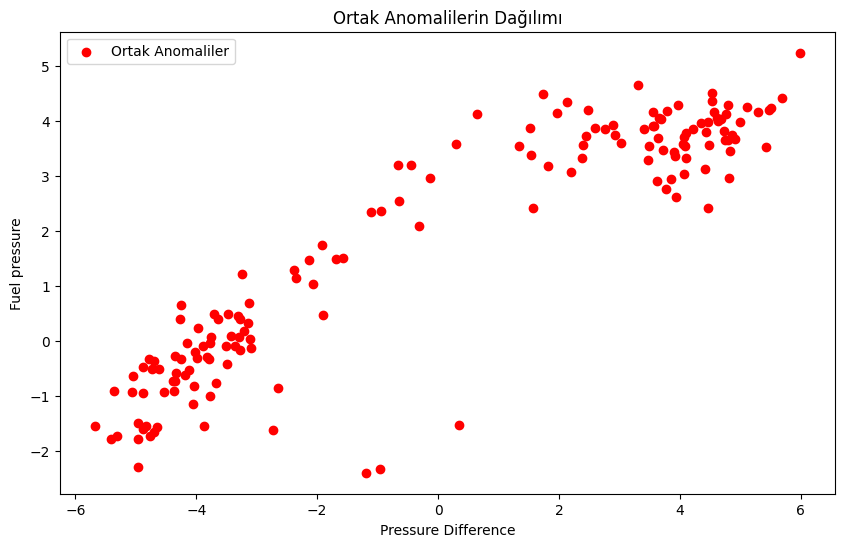

In [ ]:
X_test_with_scores, anomaly_scores, anomaly_labels = detect_anomalies_with_isolation_forest(X_train_selected, X_test_selected)

autoencoder_anomalies = anomalies  # Daha önce hesaplanan Autoencoder anomalileri

common_anomalies_indices = find_common_anomalies(
    X_test_selected.loc[autoencoder_anomalies],
    X_test_with_scores[X_test_with_scores['Anomaly_Label'] == -1]
)

visualize_common_anomalies(
    X_test_with_scores,
    x_feature='Pressure Difference',
    y_feature='Fuel pressure',
    common_indices=common_anomalies_indices
)

In [ ]:
common_anomalies_data = X_test_with_scores.loc[common_anomalies_indices]

In [ ]:
def perform_clustering(data, n_clusters=3):
    """
    küme etiketlerini döndürür.
    """
    data_cleaned = data.drop(columns=['Anomaly_Score', 'Anomaly_Label'])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_cleaned)
    data['Cluster'] = kmeans.labels_
    return data, kmeans

def visualize_clusters(data, x_feature, y_feature):

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=data[x_feature],
        y=data[y_feature],
        hue=data['Cluster'],
        palette='viridis'
    )
    plt.title('Ortak Anomaliler - Kümeleme Sonuçları')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.legend(title='Cluster')
    plt.show()

def analyze_clusters(data):

    cluster_means = data.groupby('Cluster').mean()
    print(cluster_means)

    cluster_means.plot(kind='bar', figsize=(12, 8), title='Kümelere Göre Ortalama Özellik Değerleri')
    plt.ylabel('Ortalama Değer')
    plt.xlabel('Cluster')
    plt.xticks(rotation=0)
    plt.show()

    return cluster_means

def visualize_feature_distributions(data, features):

    plt.figure(figsize=(20, 15))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 2, i)
        sns.boxplot(x='Cluster', y=feature, data=data, palette='Set2')
        plt.title(f'{feature} - Cluster Bazında Dağılım')
        plt.xlabel('Cluster')
        plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

def assign_alarms(data):

    def check_alarm_extended(row):
        if row['Cluster'] == 0 and row['Coolant pressure'] < -5:
            return "Düşük Soğutma Basıncı"
        elif row['Cluster'] == 1 and row['Pressure Sum'] > 8:
            return "Aşırı Basınç"
        elif row['Cluster'] == 2 and row['Fuel pressure'] > 4:
            return "Sınır Yaklaşımı"
        elif row['Cluster'] == 0 and row['Pressure Difference'] < -4:
            return "Basınç Farkı Sorunu"
        elif row['Cluster'] == 1 and row['RPM Coolant Pressure Product'] > 8:
            return "RPM-Soğutma Uyum Sorunu"
        elif row['Cluster'] == 2 and row['Coolant pressure'] > 5:
            return "Soğutma Basıncı Yüksek"
        else:
            return "Normal"

    data['Alarm_Extended'] = data.apply(check_alarm_extended, axis=1)
    return data

def visualize_alarm_frequencies(data):

    alarm_frequencies = data['Alarm_Extended'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=alarm_frequencies.index, y=alarm_frequencies.values, palette="viridis")
    plt.title("Alarm Türlerine Göre Dağılım")
    plt.xlabel("Alarm Türü")
    plt.ylabel("Frekans")
    plt.xticks(rotation=45)
    plt.show()

def save_alarm_logs(data, filename="alarm_logs.csv"):

    data.to_csv(filename, index=False)
    print(f"Alarm verileri kaydedildi: {filename}")

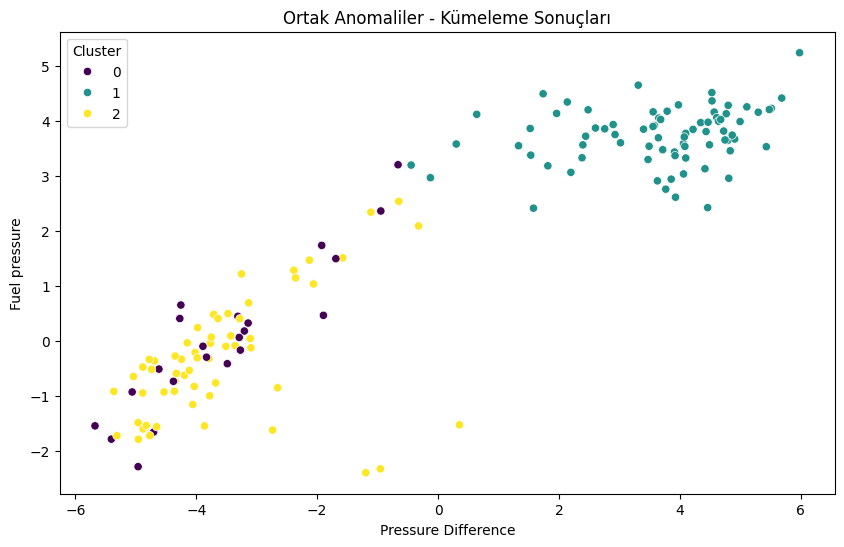

         Pressure Difference  Fuel pressure  Pressure Sum  \
Cluster                                                     
0                  -3.539441       0.045789     -0.534714   
1                   3.631448       3.737388      3.916065   
2                  -3.566196      -0.310262     -0.461984   

         RPM Coolant Pressure Product  Coolant pressure  Anomaly_Score  \
Cluster                                                                  
0                            4.699587          3.585230      -0.093459   
1                           -0.183425          0.105940      -0.056872   
2                           -2.576891          3.255935      -0.061946   

         Anomaly_Label  
Cluster                 
0                 -1.0  
1                 -1.0  
2                 -1.0  


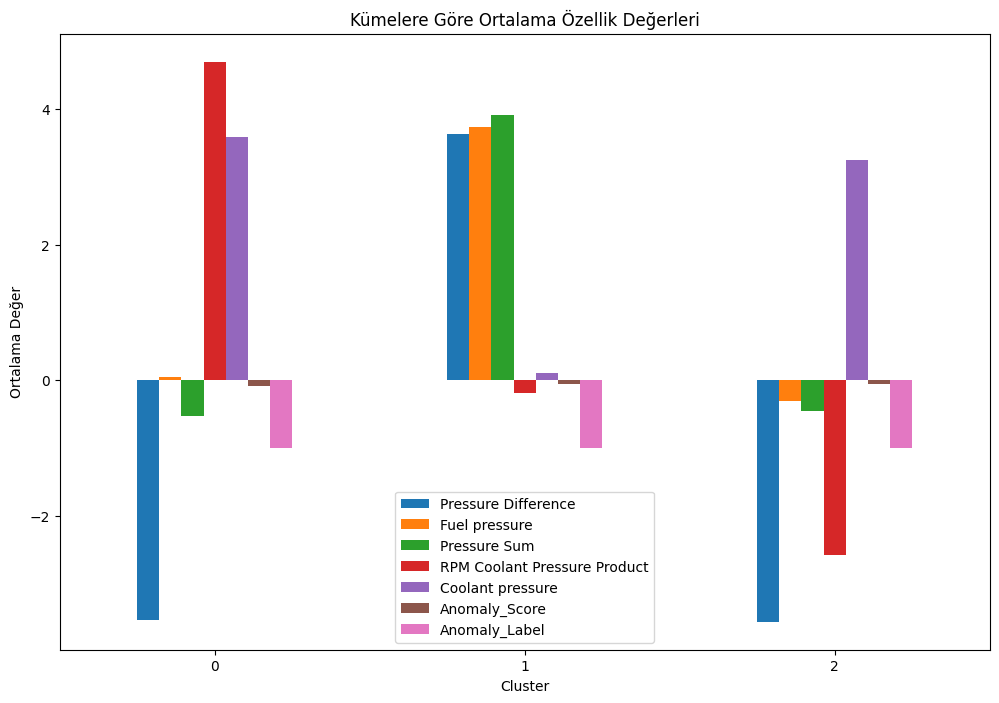

<ipython-input-61-9380b7f432b1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='Set2')
<ipython-input-61-9380b7f432b1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='Set2')
<ipython-input-61-9380b7f432b1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=data, palette='Set2')
<ipython-input-61-9380b7f432b1>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

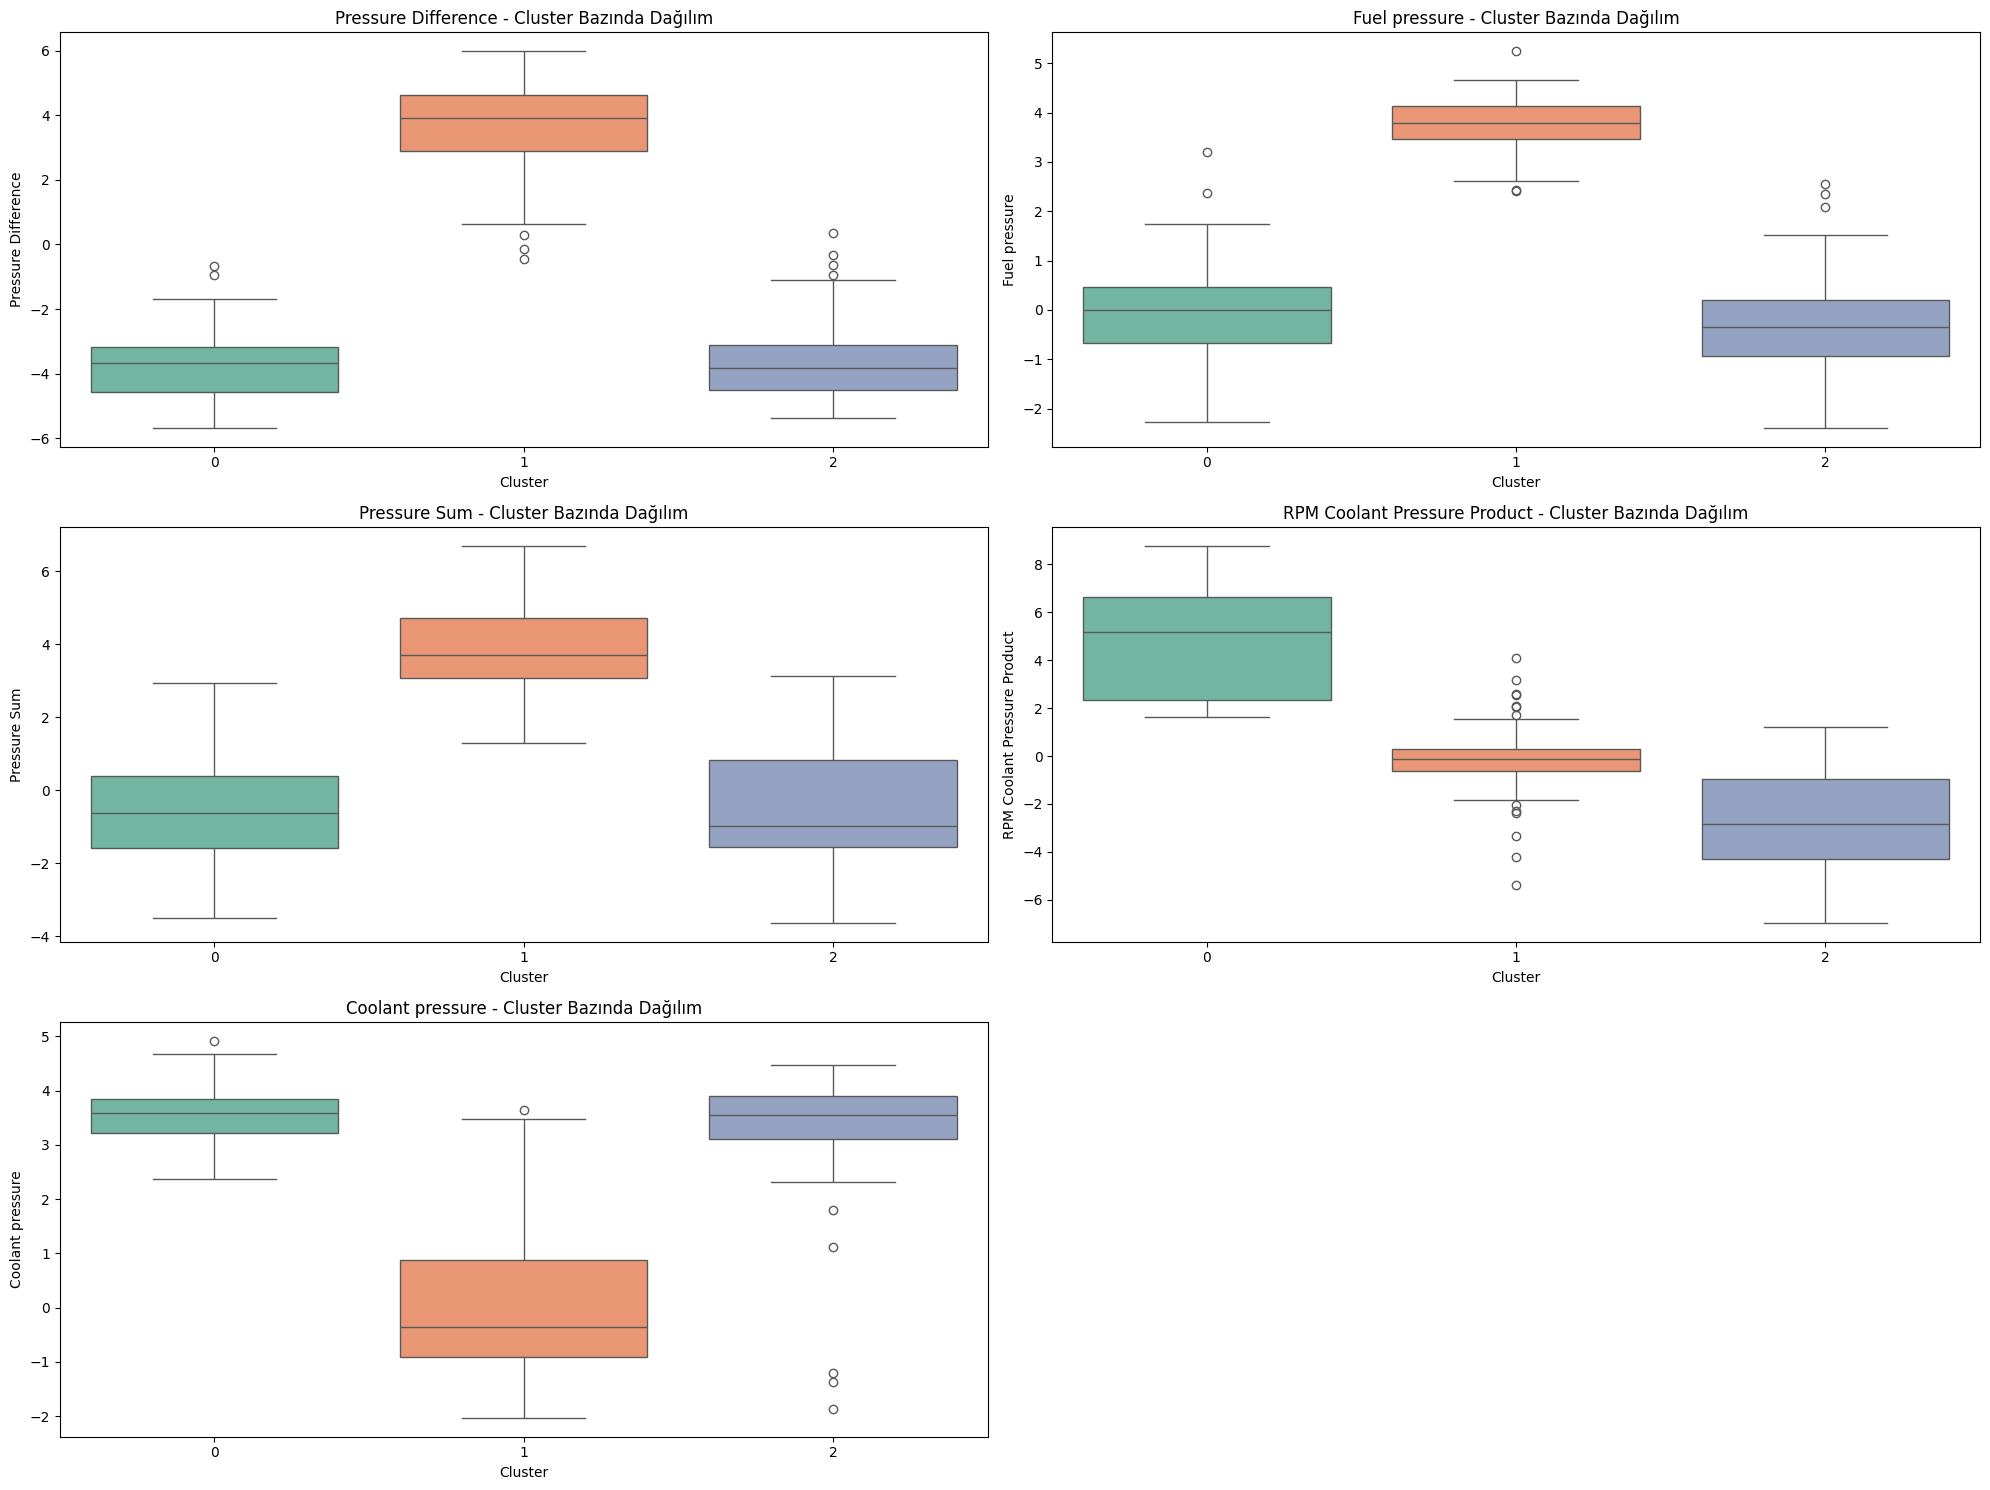

<ipython-input-61-9380b7f432b1>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=alarm_frequencies.index, y=alarm_frequencies.values, palette="viridis")


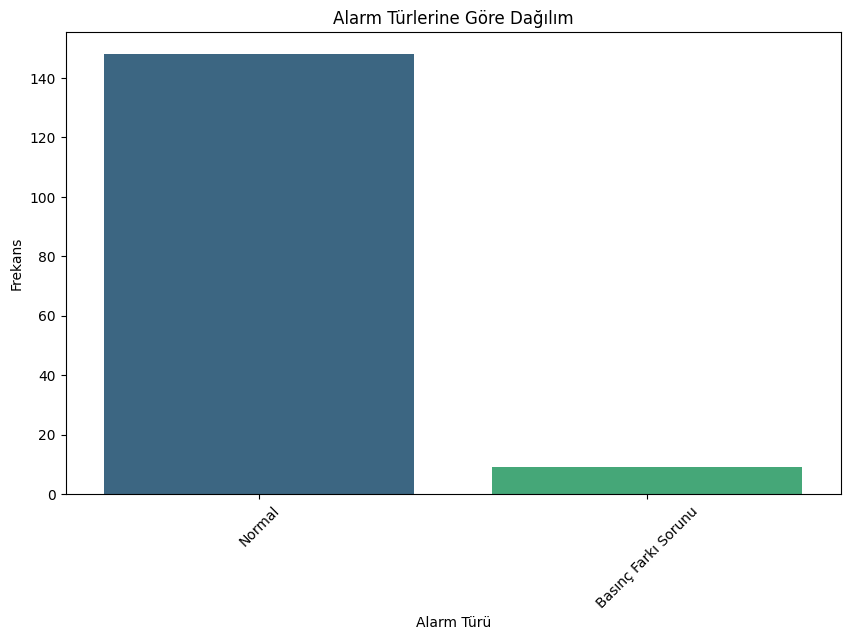

Alarm verileri kaydedildi: alarm_logs.csv


In [ ]:
# Gruplama işlemleri
common_anomalies_data, kmeans = perform_clustering(common_anomalies_data)

visualize_clusters(common_anomalies_data, 'Pressure Difference', 'Fuel pressure')

cluster_means = analyze_clusters(common_anomalies_data)

features_to_analyze = ['Pressure Difference', 'Fuel pressure', 'Pressure Sum', 'RPM Coolant Pressure Product', 'Coolant pressure']
visualize_feature_distributions(common_anomalies_data, features_to_analyze)

common_anomalies_data = assign_alarms(common_anomalies_data)

visualize_alarm_frequencies(common_anomalies_data)

save_alarm_logs(common_anomalies_data)

Veri Bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Pressure Difference           157 non-null    float64
 1   Fuel pressure                 157 non-null    float64
 2   Pressure Sum                  157 non-null    float64
 3   RPM Coolant Pressure Product  157 non-null    float64
 4   Coolant pressure              157 non-null    float64
 5   Anomaly_Score                 157 non-null    float64
 6   Anomaly_Label                 157 non-null    int64  
 7   Cluster                       157 non-null    int64  
 8   Alarm_Extended                157 non-null    object 
dtypes: float64(6), int64(2), object(1)
memory usage: 11.2+ KB
None

Veri Özeti:
       Pressure Difference  Fuel pressure  Pressure Sum  \
count           157.000000     157.000000    157.000000   
mean             -0.032392       1

<ipython-input-64-6226cd7fa584>:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts_data.index = pd.date_range(start='2023-01-01', periods=len(ts_data), freq='H')  # Varsayılan zaman aralığı



ARIMA Model Özeti:
                                SARIMAX Results                                
Dep. Variable:     Pressure Difference   No. Observations:                  157
Model:                  ARIMA(1, 1, 1)   Log Likelihood                -433.917
Date:                 Thu, 05 Dec 2024   AIC                            873.834
Time:                         22:31:42   BIC                            882.984
Sample:                     01-01-2023   HQIC                           877.550
                          - 01-07-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0538      0.083     -0.648      0.517      -0.216       0.109
ma.L1         -0.9999      2.477     -0.404      0.686      -5.855       3.855
sigma2        14.7635   

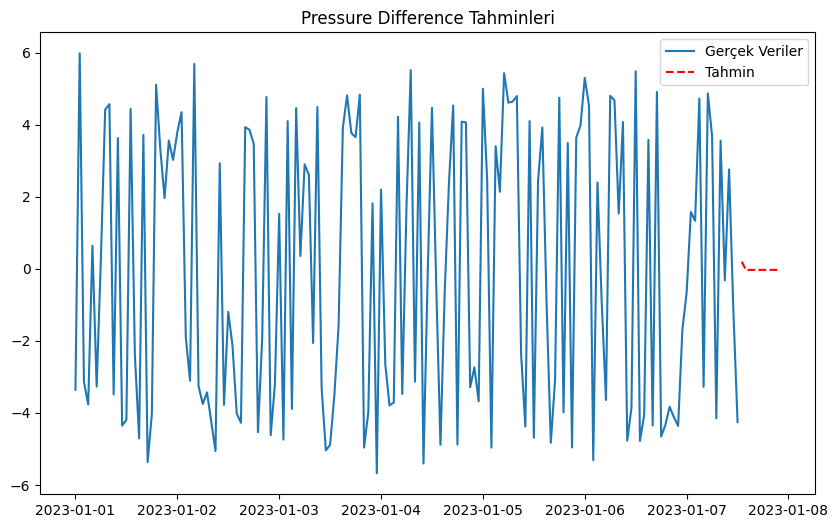

In [ ]:
def load_and_prepare_logs(filepath):
    logs_df = pd.read_csv(filepath)
    print("Veri Bilgisi:")
    print(logs_df.info())
    print("\nVeri Özeti:")
    print(logs_df.describe())
    return logs_df

def train_and_evaluate_classifier(logs_df):
    """
    Random Forest modeli ile alarm türlerini sınıflandırır.
    """
    X = logs_df.drop(columns=["Alarm_Extended"])
    y = logs_df["Alarm_Extended"]

    y_encoded = pd.get_dummies(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    print("\nRandom Forest Model Performansı:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

    return rf

def perform_time_series_forecast(logs_df, column_name="Pressure Difference", steps=10):
    """
    ARIMA modeli kullanarak zaman serisi tahmini yapar.
    """
    ts_data = logs_df[[column_name]].copy()
    ts_data.index = pd.date_range(start='2023-01-01', periods=len(ts_data), freq='H')  # Varsayılan zaman aralığı

    model = ARIMA(ts_data, order=(1, 1, 1))
    results = model.fit()

    print("\nARIMA Model Özeti:")
    print(results.summary())

    forecast = results.forecast(steps=steps)
    print(f"\nSonraki {steps} zaman adımı için tahminler:\n{forecast}")

    plt.figure(figsize=(10, 6))
    plt.plot(ts_data, label="Gerçek Veriler")
    plt.plot(forecast, label="Tahmin", linestyle="--", color="red")
    plt.title(f"{column_name} Tahminleri")
    plt.legend()
    plt.show()

    return results, forecast

def main():

    filepath = "alarm_logs.csv"
    logs_df = load_and_prepare_logs(filepath)
    train_and_evaluate_classifier(logs_df)

    perform_time_series_forecast(logs_df, column_name="Pressure Difference", steps=10)


if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
from scipy.spatial import cKDTree

def find_nearest_neighbors(source_df, target_df, key_columns):
    """
    İki veri kümesi arasında en yakın komşuları bulur ve birleştirir.
    """
    source_matrix = source_df[key_columns].to_numpy()
    target_matrix = target_df[key_columns].to_numpy()

    tree = cKDTree(source_matrix)
    distances, indices = tree.query(target_matrix)

    target_df["Nearest_Index"] = indices
    return target_df.merge(source_df, left_on="Nearest_Index", right_index=True, suffixes=('_alarm', '_engine'))


engine_filepath = "engine_data.csv"
alarm_filepath = "alarm_logs.csv"

engine_data = pd.read_csv(engine_filepath)
alarm_logs = pd.read_csv(alarm_filepath)


engine_data['Pressure Difference'] = engine_data['Fuel pressure'] - engine_data['Coolant pressure']

key_columns = ['Fuel pressure', 'Coolant pressure', 'Pressure Difference']
merged_data = find_nearest_neighbors(engine_data, alarm_logs, key_columns)


print("Birleştirilmiş Veri:")
print(merged_data.head())

merged_data.to_csv("merged_alarm_engine_data.csv", index=False)

print(merged_data.info())

Birleştirilmiş Veri:
   Pressure Difference_alarm  Fuel pressure_alarm  Pressure Sum  \
0                  -3.356913            -0.083759      2.033573   
1                   5.981594             5.245553      5.875056   
2                  -3.141556             0.328859      2.932245   
3                  -3.765307            -0.038610     -0.345051   
4                   0.640665             4.125055      6.687924   

   RPM Coolant Pressure Product  Coolant pressure_alarm  Anomaly_Score  \
0                     -2.277952                3.273154      -0.041970   
1                     -0.040599               -0.736041      -0.084447   
2                      6.753462                3.470415      -0.118524   
3                     -2.426481                3.726697      -0.047990   
4                     -3.349430                3.484390      -0.130008   

   Anomaly_Label  Cluster Alarm_Extended  Nearest_Index  Engine rpm  \
0             -1        2         Normal           9698     

Alarm Türlerine Göre Anomali Sayısı:
   Engine Condition       Alarm_Extended  Alarm_Count
0                 0  Basınç Farkı Sorunu            9
1                 0               Normal          113
2                 1  Basınç Farkı Sorunu            1
3                 1               Normal           76

Motor Koşullarına Göre Analiz:
   Engine Condition  Anomaly_Label  Fuel pressure_engine  \
0                 0           -122              1.551321   
1                 1            -77              3.081172   

   Coolant pressure_engine  
0                 2.371087  
1                 1.259533  


<ipython-input-10-c4ed0cfdedb4>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


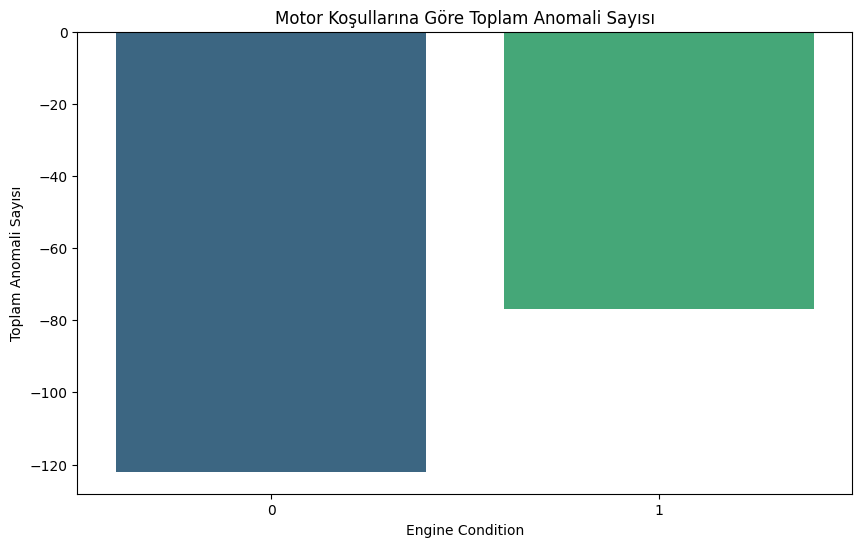

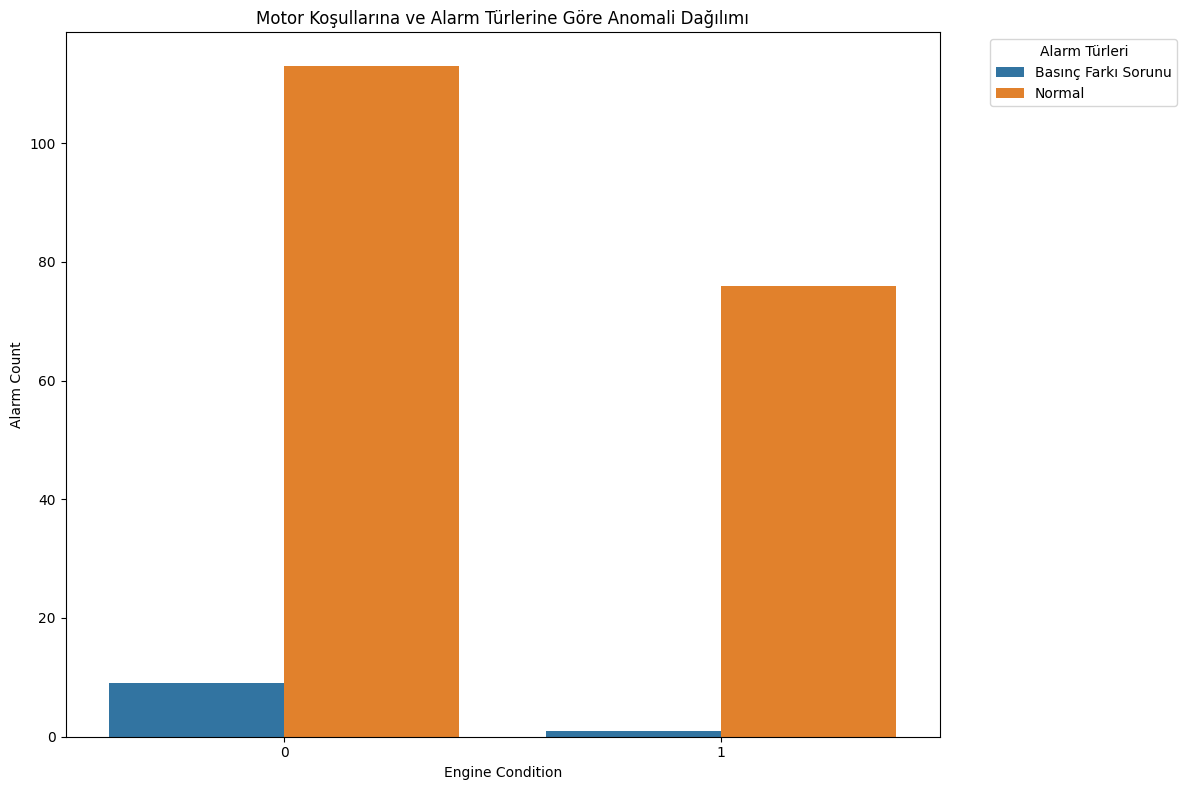

In [ ]:
data = pd.read_csv("merged_alarm_engine_data.csv")


anomaly_count = data.groupby(['Engine Condition', 'Alarm_Extended']).size().reset_index(name='Alarm_Count')

engine_condition_analysis = data.groupby('Engine Condition').agg({
    'Anomaly_Label': 'sum',  # Toplam anomali sayısı
    'Fuel pressure_engine': 'mean',
    'Coolant pressure_engine': 'mean'
}).reset_index()

print("Alarm Türlerine Göre Anomali Sayısı:")
print(anomaly_count)
print("\nMotor Koşullarına Göre Analiz:")
print(engine_condition_analysis)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Engine Condition',
    y='Anomaly_Label',
    data=engine_condition_analysis,
    palette='viridis'
)
plt.title("Motor Koşullarına Göre Toplam Anomali Sayısı")
plt.xlabel("Engine Condition")
plt.ylabel("Toplam Anomali Sayısı")
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Engine Condition',
    y='Alarm_Count',
    hue='Alarm_Extended',
    data=anomaly_count,
    palette='tab10'
)
plt.title("Motor Koşullarına ve Alarm Türlerine Göre Anomali Dağılımı")
plt.xlabel("Engine Condition")
plt.ylabel("Alarm Count")
plt.legend(title="Alarm Türleri", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_csv("merged_alarm_engine_data.csv")

app = dash.Dash(__name__)

anomaly_bar = px.bar(
    data.groupby("Engine Condition")["Anomaly_Label"].count().reset_index(),
    x="Engine Condition",
    y="Anomaly_Label",
    title="Motor Koşullarına Göre Anomaliler",
    labels={"Anomaly_Label": "Anomali Sayısı", "Engine Condition": "Motor Koşulu"}
)

alarm_pie = px.pie(
    data,
    names="Alarm_Extended",
    title="Alarm Türlerine Göre Dağılım"
)


app.layout = html.Div(children=[
    html.H1("Motor Anomali Gösterge Panosu"),
    html.Div([
        dcc.Graph(figure=anomaly_bar),
        dcc.Graph(figure=alarm_pie)
    ]),
    html.Div([
        html.H3("Anomali Logları"),
        html.Table([
            html.Tr([html.Th(col) for col in data.columns]),
            *[html.Tr([html.Td(data.iloc[i][col]) for col in data.columns]) for i in range(10)]
        ])
    ])
])


if __name__ == "__main__":
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
